In [16]:
import numpy as np
from collections import defaultdict
import pandas as pd
import ast
from tabulate import tabulate
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from datasets import load_dataset

In [17]:
dataset = load_dataset("conll2003")

In [18]:
class HMM:
    def __init__(self, states, observations):
        """
        The initialization of the HMM class with states, observations, and probability matrices has been done.
        The use of dictionaries (state_index and observation_index) for indexing states and observations avoids potential indexing errors.
        """

        self.states = states
        self.observations = observations
        self.start_probabilities = np.zeros(len(states))
        self.transition_probabilities = np.zeros((len(states), len(states)))
        self.emission_probabilities = np.zeros((len(states), len(observations)))

        self.state_index = {state: i for i, state in enumerate(states)}
        self.observation_index = {obs: i for i, obs in enumerate(observations)}

    def compute_start_probabilities(self, sequences):
        """
        The computation of start probabilities based on the first tag of each sequence is appropriate. 
        We have handled cases where the sequence length is 0 to avoid division by zero.
        """
        for sequence in sequences:
            if(len(sequence)==0):
                continue
            start_state = sequence[0][1]  # The tag of the first token
            self.start_probabilities[self.state_index[start_state]] += 1
        self.start_probabilities /= np.sum(self.start_probabilities)

    def compute_transition_probabilities(self, sequences):
        """
        The computation of transition probabilities between states is implemented correctly. 
        We have handled cases where the sequence length is 0 to avoid division by zero.
        """
        for sequence in sequences:
            for i in range(len(sequence) - 1):
                current_state = sequence[i][1]
                next_state = sequence[i + 1][1]
                self.transition_probabilities[self.state_index[current_state], self.state_index[next_state]] += 1

        for i in range(len(self.states)):
            if(np.sum(self.transition_probabilities[i])==0):
                continue
            self.transition_probabilities[i] /= np.sum(self.transition_probabilities[i])

    def compute_emission_probabilities(self, sequences):
        """
        The computation of emission probabilities from states to observations is well-implemented. 
        We have handled cases where the sequence length is 0 to avoid division by zero.
        """
        for sequence in sequences:
            for token, state in sequence:
                self.emission_probabilities[self.state_index[state], self.observation_index[token]] += 1

        for i in range(len(self.states)):
            if(np.sum(self.emission_probabilities[i])==0):
                continue
            self.emission_probabilities[i] /= np.sum(self.emission_probabilities[i])

    def viterbi_algorithm(self, obs):
        """
        The Viterbi algorithm is correctly implemented with the necessary tables for probabilities and backpointers. 
        The logic for finding the best path is accurate.
        We have handled the case when an out of vocabulary word is encountered.
        """

        viterbi_table = [[0.0 for _ in range(len(self.states))] for _ in range(len(obs))]
        backpointer = [[0 for _ in range(len(self.states))] for _ in range(len(obs))]

        for t in range(len(obs)):
            for s in range(len(self.states)):
                if t == 0:
                    viterbi_table[t][s] = self.start_probabilities[s] * self.emission_probabilities[s][obs[t]]
                else:
                    max_prob = -1
                    max_backpointer = -1

                    for s_prime in range(len(self.states)):
                        prob = viterbi_table[t-1][s_prime] * self.transition_probabilities[s_prime][s] * self.emission_probabilities[s][obs[t]]
                        if prob > max_prob:
                            max_prob = prob
                            max_backpointer = s_prime

                    viterbi_table[t][s] = max_prob
                    backpointer[t][s] = max_backpointer

        best_path_pointer = max(range(len(self.states)), key=lambda s: viterbi_table[-1][s])
        best_path = [best_path_pointer]
        for t in range(len(obs)-1, 0, -1):
            best_path.insert(0, backpointer[t][best_path[0]])

        return best_path

In [19]:
def threshold_data(sequences, threshold):
    word_counts = defaultdict(int)
    for sequence in sequences:
        for token, state in sequence:
            word_counts[token] += 1

    unk_sequences = []
    for sequence in sequences:
        unk_sequence = [(token if word_counts[token] > threshold else 'UNK', state) for token, state in sequence]
        unk_sequences.append(unk_sequence)

    return unk_sequences

In [20]:
def train_hmm(hmm_model, sequences):
    hmm_model.compute_start_probabilities(sequences)
    hmm_model.compute_transition_probabilities(sequences)
    hmm_model.compute_emission_probabilities(sequences)

In [21]:
def get_hmm_model(train_df, test_df):
    train_data = [(row['tokens'], row['ner_tags']) for _, row in train_df.iterrows()]
    unique_tags = set(tag for _, tags in train_data for tag in tags)
    states = list(unique_tags)
    sequences = [list(zip(tokens, tags)) for tokens, tags in train_data]
    sequences = threshold_data(sequences, 5)

    unique_tokens = set()
    for sequence in sequences:
        for token, _ in sequence:
            unique_tokens.add(token)

    unique_tokens_list = list(unique_tokens)

    hmm_model = HMM(states, unique_tokens_list)

    train_hmm(hmm_model, sequences)

    test_tokens = test_df['tokens']
    test_ner_tags = test_df['ner_tags']

    N_test = len(test_tokens)

    return hmm_model, N_test, test_tokens, test_ner_tags, states

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from seaborn import heatmap
import seaborn as sns

def compute_metrics(true_tags, predicted_tags, accuracy, states):
    # Exclude state 0 (OTHER) from the list of states
    states = [state for state in states if state != 0]

    print("\nOverall Metrics (excluding 'OTHER'):")
    print("Accuracy:", accuracy)
    print(classification_report(true_tags, predicted_tags, zero_division=1, labels=states))

    print("\nPer-State Metrics (excluding 'OTHER'):")
    per_state_report = classification_report(true_tags, predicted_tags, labels=states, output_dict=True, zero_division=1)

    precision_values = [per_state_report[str(state)]['precision'] for state in states]
    recall_values = [per_state_report[str(state)]['recall'] for state in states]
    f1_score_values = [per_state_report[str(state)]['f1-score'] for state in states]
    support_values = [per_state_report[str(state)]['support'] for state in states]
    state_accuracy_values = [
        sum(1 for true, pred in zip(true_tags, predicted_tags) if true == state and pred == state) / true_tags.count(state) if true_tags.count(state) > 0 else 0
        for state in states
    ]

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    fig.suptitle("Metrics Comparison for Different Entity Types (excluding 'OTHER')", fontsize=16)

    axes[0, 0].bar(states, precision_values, color='skyblue')
    axes[0, 0].set_title("Precision")
    axes[0, 0].set_ylabel("Score")

    axes[0, 1].bar(states, recall_values, color='lightcoral')
    axes[0, 1].set_title("Recall")
    axes[0, 1].set_ylabel("Score")

    axes[1, 0].bar(states, f1_score_values, color='lightgreen')
    axes[1, 0].set_title("F1-Score")
    axes[1, 0].set_ylabel("Score")

    support_bars = axes[1, 1].bar(states, support_values, color='gold')
    axes[1, 1].set_title("Support")
    axes[1, 1].set_ylabel("Count")

    for bar, support_value in zip(support_bars, support_values):
        axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(support_value), ha='center', va='bottom')

    axes[2, 0].bar(states, state_accuracy_values, color='orchid')
    axes[2, 0].set_title("State-wise Accuracy")
    axes[2, 0].set_ylabel("Accuracy")

    fig.delaxes(axes[2, 1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\nConfusion Matrix (excluding 'OTHER'):")
    plt.figure(figsize=(16, 10))
    conf_matrix = confusion_matrix(true_tags, predicted_tags, labels=states)
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=states, yticklabels=states)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (excluding 'OTHER')")
    plt.show()

In [23]:
def plot_misclassification_rates(states, true_tags, predicted_tags):
    misclassification_rates = {state: 0 for state in states}
    
    for true_tag, predicted_tag in zip(true_tags, predicted_tags):
        if true_tag != predicted_tag:
            misclassification_rates[true_tag] += 1

    misclassification_rates = {
        state: misclassification_rates[state] / true_tags.count(state) if true_tags.count(state) > 0 else 0
        for state in states
    }    
    
    sorted_states = sorted(states, key=lambda state: misclassification_rates[state], reverse=True)

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_states, [misclassification_rates[state] for state in sorted_states], color='coral')
    plt.xlabel("Entity Types")
    plt.ylabel("Misclassification Rate")
    plt.title("Misclassification Rates for Different Entity Types")
    plt.show()

In [24]:
def evaluate_model(hmm_model, test_ner_tags, test_tokens, N_test, states):
    true_tags_all = []
    predicted_tags_all = []

    correct = 0
    total = 0
    for idx in range(N_test):
        tags = eval(test_ner_tags[idx])
        observations = [obs for obs in eval(test_tokens[idx])]
        if len(observations) == 0:
            continue
        
        observed_tokens = [tok for tok in eval(test_ner_tags[idx])]
        # observation_indices = [hmm_model.observation_index.get(obs, len(hmm_model.observations)) for obs in observations]

        observation_indices = [
            hmm_model.observation_index[obs] if obs in hmm_model.observation_index else hmm_model.observation_index['UNK']
            for obs in observations
        ]
        
        predicted_tags = hmm_model.viterbi_algorithm(observation_indices)
        
        true_tags_all.extend(tags)
        predicted_tags_all.extend([states[tag] for tag in predicted_tags])
        
        for i in range(len(predicted_tags)):
            if predicted_tags[i] == observed_tokens[i]:
                correct += 1

        total += len(observations)
        
    accuracy = correct / total

    compute_metrics(true_tags_all, predicted_tags_all, accuracy, states)
    plot_misclassification_rates(states, true_tags_all, predicted_tags_all)

In [25]:
df_train_lstm = pd.read_csv('../cross_domain/lstm_train.csv' , converters={'tokens': ast.literal_eval, 'ner_tags': ast.literal_eval})
test_lstm = pd.read_csv('../cross_domain/lstm_test.csv')

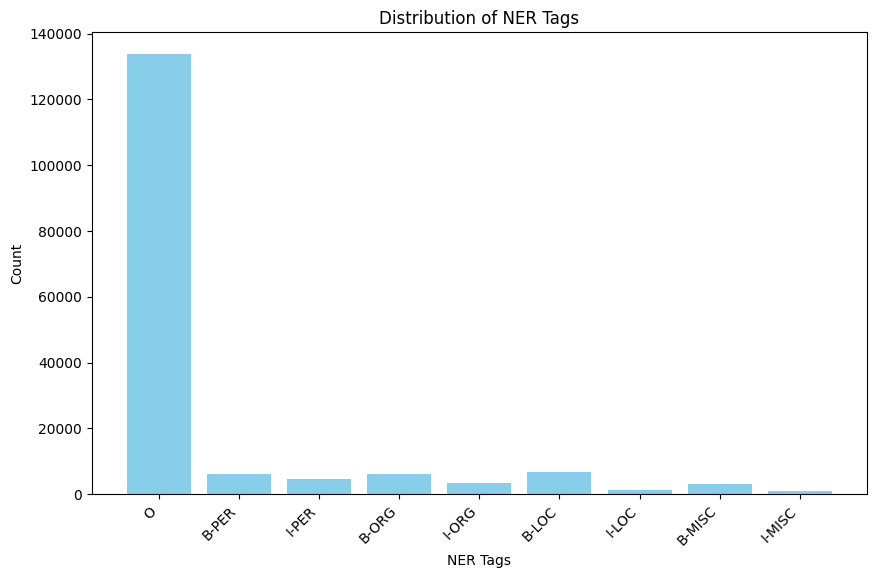

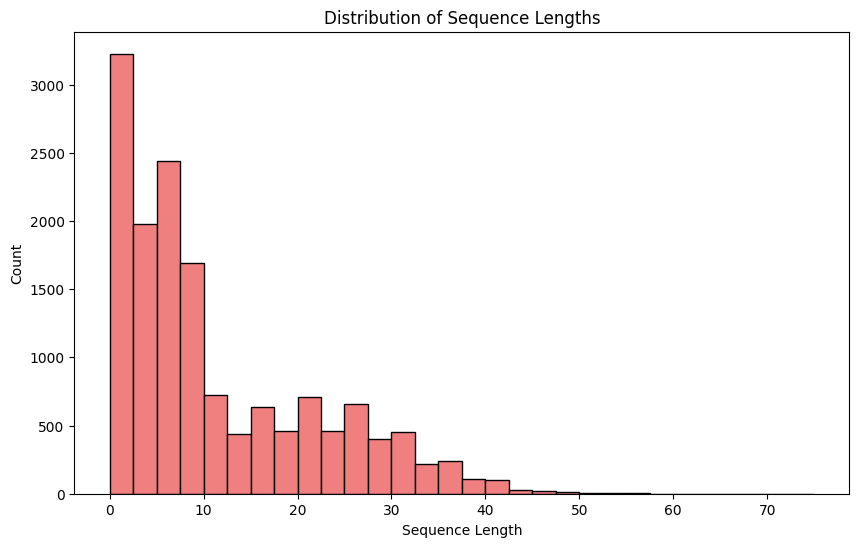

Number of unique tokens: 13029


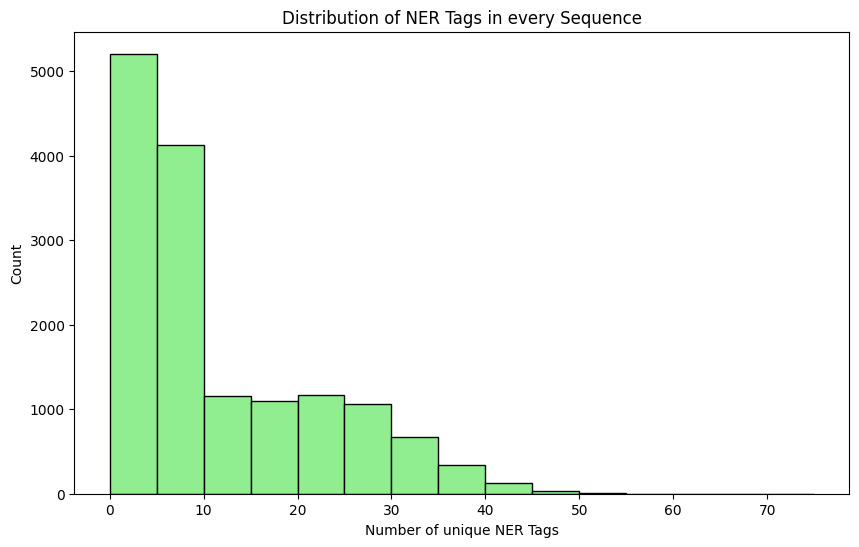

In [26]:
ner_tags =  ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]
ner_distribution_dict = {i: 0 for i in range(len(ner_tags))}

ner_distribution = df_train_lstm['ner_tags'].explode().value_counts().sort_index()
ner_distribution_dict.update(ner_distribution)
ner_distribution = pd.Series(ner_distribution_dict)

plt.figure(figsize=(10, 6))
plt.bar(ner_tags, ner_distribution, color='skyblue')
plt.title('Distribution of NER Tags')
plt.xticks(rotation=45, ha='right')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.show()

df_train_lstm['sequence_length'] = df_train_lstm['tokens'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df_train_lstm['sequence_length'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

unique_tokens_distribution = df_train_lstm['tokens'].explode().nunique()
print(f"Number of unique tokens: {unique_tokens_distribution}")

ner_per_sequence_distribution = df_train_lstm['ner_tags'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(ner_per_sequence_distribution, bins=15, color='lightgreen', edgecolor='black')
plt.title('Distribution of NER Tags in every Sequence')
plt.xlabel('Number of unique NER Tags')
plt.ylabel('Count')
plt.show()


Overall Metrics (excluding 'OTHER'):
Accuracy: 0.8934966015180767
              precision    recall  f1-score   support

           1       0.66      0.53      0.58      1570
           2       0.65      0.65      0.65      1134
           3       0.68      0.56      0.61      1619
           4       0.56      0.46      0.51       819
           5       0.84      0.70      0.76      1600
           6       0.60      0.48      0.53       257
           7       0.83      0.67      0.74       646
           8       0.55      0.60      0.58       204

   micro avg       0.69      0.59      0.64      7849
   macro avg       0.67      0.58      0.62      7849
weighted avg       0.70      0.59      0.64      7849


Per-State Metrics (excluding 'OTHER'):


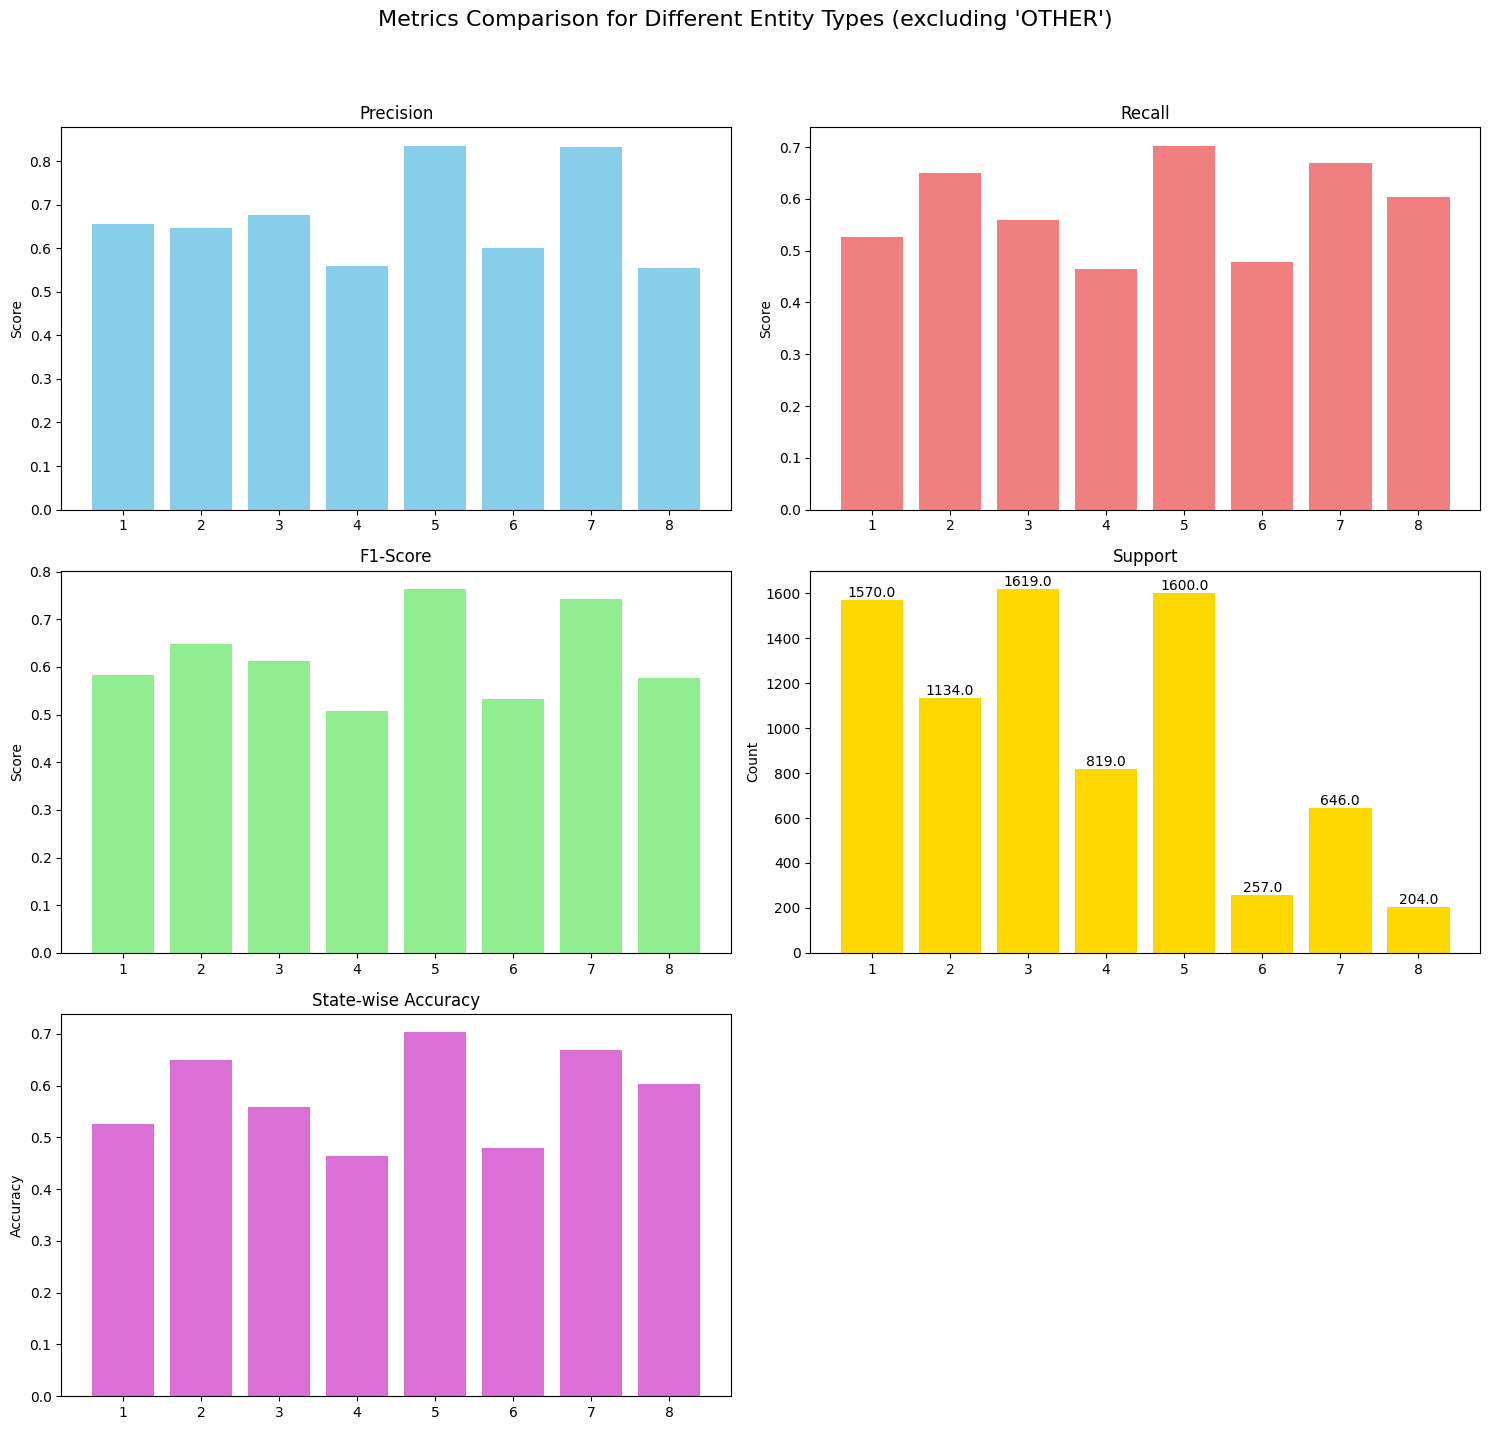


Confusion Matrix (excluding 'OTHER'):


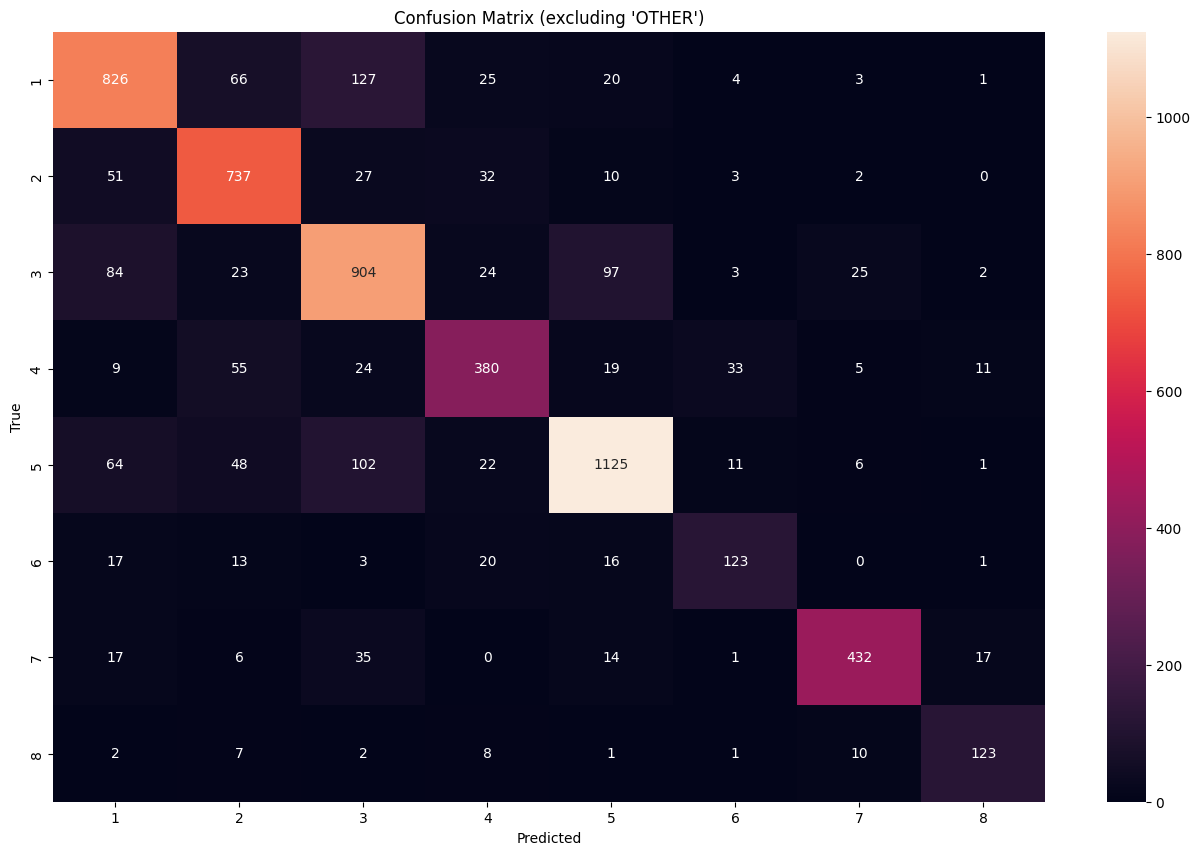

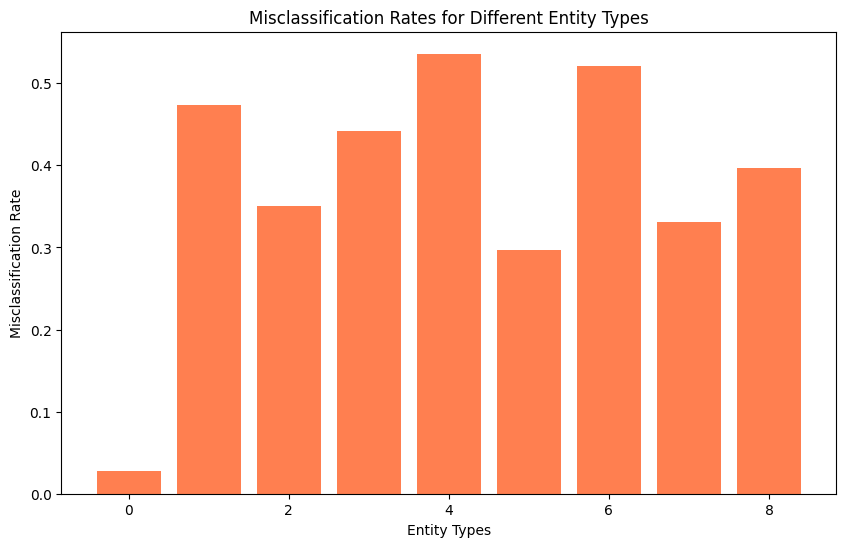

In [27]:
hmm_model, N_test, test_tokens, test_ner_tags, states  = get_hmm_model(df_train_lstm, test_lstm)
evaluate_model(hmm_model, test_ner_tags, test_tokens, N_test, np.arange(len(ner_tags)))